# Predicting Euro 2024 Football Team Scores using XGBoost


---

This notebook's CI test result for eu-west-2 is as follows.

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

---

_**Using Gradient Boosted Trees to Predict Football team score**_

---

---

## Runtime

This notebook takes approximately 10 minutes to run.

## Contents

1. Loading Libraries
2. Loading the Dataset
3. Exploratory Data Analysis (EDA)
4. Data Preprocessing
5. Model Building
6. Model Tuning
7. Model Evaluation
8. Conclusion

---

## Background

_This notebook has been adapted from an [AWS blog post](https://aws.amazon.com/blogs/ai/predicting-customer-churn-with-amazon-machine-learning/)_


This notebook demonstratess the application of XGBoost to predict football team match outcomes using the Euro dataset. We will guide you through data loading, preprocessing, model training, and evaluation steps.

Predicting football match outcomes offers valuable insights for teams, coaches, and analysts. By analyzing historical match data, we can forecast future results, supporting strategic planning and decision-making. This notebook focuses on leveraging machine learning (ML) techniques to predict match scores, specifically targeting teams participating in the Euro 2024 tournament.

Using historical match data, our goal is to build a model capable of predicting current match scores based on various features such as team formations and past match performances. Accurate predictions can empower teams to refine strategies, identify strengths, and address weaknesses, potentially enhancing their competitive edge.

Throughout this notebook, we will demonstrate how to train an XGBoost model on SageMaker and deploy an endpoint for real-time inference.

---

## Setup

_This notebook was created and tested on a `ml.m4.xlarge` notebook instance._

Let's start by updating the required packages i.e. SageMaker Python SDK, `pandas` and `numpy`, and specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance or Studio, training, and hosting.
- The IAM role ARN used to give training and hosting access to your data. See the documentation for how to create these.  Note: if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with the appropriate full IAM role ARN string(s).

In [2]:
import sys

!{sys.executable} -m pip install sagemaker pandas numpy --upgrade
!pip3 install -U sagemaker
!pip3 install -U seaborn

  Using cached sagemaker-2.226.0-py3-none-any.whl.metadata (15 kB)
  Using cached numpy-2.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached boto3-1.34.144-py3-none-any.whl.metadata (6.6 kB)
  Using cached botocore-1.34.144-py3-none-any.whl.metadata (5.7 kB)
Using cached sagemaker-2.226.0-py3-none-any.whl (1.5 MB)
Using cached boto3-1.34.144-py3-none-any.whl (139 kB)
Using cached botocore-1.34.144-py3-none-any.whl (12.4 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.84
    Uninstalling botocore-1.34.84:
      Successfully uninstalled botocore-1.34.84
  Attempting uninstall: boto3
    Found existing installation: boto3 1.34.84
    Uninstalling boto3-1.34.84:
      Successfully uninstalled boto3-1.34.84
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.215.0
    Uninstalling sagemaker-2.215.0:
      Successfully uninstalled sagemaker-2.215.0
ERROR: pip's dependency resolver does 

Next, we'll import the Python libraries we'll need for the remainder of the example.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import matplotlib.pyplot as plt
import seaborn as sns
import re
import boto3
import sagemaker
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
from sagemaker import get_execution_role

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


Now, we need to define our session, bucket and execution role.

In [4]:
role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket() 

---
## Data

Football teams have historical records of match outcomes, player statistics, team formations, and other relevant metrics. We can use this historical information to construct an ML model to predict the score of a current match using a process called training. After training the model, we can input the details of an upcoming match (using the same type of data that we used to train the model), and have the model predict the expected score. Naturally, we expect the model to make some errors, as predicting match outcomes can be quite complex. However, we will learn how to handle and interpret these prediction errors.

The dataset we use includes historical data on Euro 2024 teams from various leagues, containing information such as team formations, player statistics, match outcomes, and other relevant features. This data will allow us to build a robust model to predict match scores.

Let's download and read this dataset now:

In [5]:
key_prefix = f"data_science_club_tau/fixtures_merged_statistics_df.csv"

In [6]:
s3 = boto3.client("s3")
s3.download_file(bucket,key_prefix,"fixtures_merged_statistics_df.csv")

Load the data into a pandas dataframe

In [7]:
fixtures = pd.read_csv("./fixtures_merged_statistics_df.csv")
pd.set_option("display.max_columns", 500)

## Exploratory Data Analysis (EDA)
In this section, we will conduct preliminary exploratory data analysis to gain a deeper understanding of the dataset.

In [8]:
len(fixtures.columns)

51

In [9]:
fixtures.columns

Index(['fixture_id', 'home_articipant', 'away_articipant', 'start_date',
       'leagueName', 'home_team_formation', 'away_team_formation',
       'home_yellow_cards', 'home_red_cards', 'away_yellow_cards',
       'away_red_cards', 'home_score', 'away_score', 'home_score_half_time',
       'away_score_half_time', 'home_score_conceded', 'away_score_conceded',
       'time_to_first_goal', 'time_to_first_goal_home_team',
       'time_to_first_goal_away_team', 'first_team_to_score',
       'first_team_to_score_is_home', 'first_team_to_score_is_away',
       'home_score_ratio', 'away_score_ratio', 'away_ball_possession',
       'away_corner_kicks', 'away_fouls', 'away_free_kicks', 'away_goal_kicks',
       'away_goalkeeper_saves', 'away_offsides', 'away_shots_off_target',
       'away_shots_on_target', 'away_throw_ins', 'away_total_shots',
       'home_ball_possession', 'home_corner_kicks', 'home_fouls',
       'home_free_kicks', 'home_goal_kicks', 'home_goalkeeper_saves',
       'home_offs

In [10]:
fixtures.head()

,fixture_id,home_articipant,away_articipant,start_date,leagueName,home_team_formation,away_team_formation,home_yellow_cards,home_red_cards,away_yellow_cards,away_red_cards,home_score,away_score,home_score_half_time,away_score_half_time,home_score_conceded,away_score_conceded,time_to_first_goal,time_to_first_goal_home_team,time_to_first_goal_away_team,first_team_to_score,first_team_to_score_is_home,first_team_to_score_is_away,home_score_ratio,away_score_ratio,away_ball_possession,away_corner_kicks,away_fouls,away_free_kicks,away_goal_kicks,away_goalkeeper_saves,away_offsides,away_shots_off_target,away_shots_on_target,away_throw_ins,away_total_shots,home_ball_possession,home_corner_kicks,home_fouls,home_free_kicks,home_goal_kicks,home_goalkeeper_saves,home_offsides,home_shots_off_target,home_shots_on_target,home_throw_ins,home_total_shots,total_offsides_dependent,total_red_cards_dependent,total_yellow_cards_dependent,total_corner_kicks_dependent
0,5076758,Greece,Romania,2014-09-07,european_championship,4|2|3|1,4|2|3|1,5.0,0.0,4.0,1.0,0,1,0,1,1,0,10,130,10,Away,0,1,0.000,0.000,36%,2.0,18.0,11.0,9.0,2.0,2.0,5.0,3.0,22.0,8.0,64%,3.0,11.0,18.0,8.0,2.0,2.0,5.0,2.0,31.0,11.0,4.0,1.0,9.0,5.0
1,5076974,Germany,Scotland,2014-09-07,european_championship,4|2|3|1,4|2|3|1,2.0,0.0,4.0,1.0,2,1,1,0,1,2,18,18,66,Home,1,0,1.000,1.000,35%,1.0,15.0,14.0,13.0,8.0,3.0,4.0,3.0,23.0,7.0,65%,12.0,13.0,18.0,4.0,2.0,1.0,11.0,11.0,19.0,22.0,4.0,1.0,6.0,13.0
2,5076624,Denmark,Armenia,2014-09-07,european_championship,5|3|2,5|3|2,1.0,0.0,1.0,0.0,2,1,0,0,1,2,50,65,50,Away,0,1,1.000,1.000,36%,2.0,12.0,15.0,15.0,4.0,2.0,2.0,2.0,15.0,4.0,64%,7.0,14.0,14.0,2.0,1.0,1.0,9.0,6.0,18.0,15.0,3.0,0.0,2.0,9.0
3,5076754,Hungary,Northern Ireland,2014-09-07,european_championship,4|2|3|1,4|2|3|1,1.0,0.0,1.0,0.0,1,2,0,0,2,1,75,75,81,Home,1,0,0.333,0.333,47%,2.0,18.0,13.0,10.0,5.0,1.0,4.0,4.0,21.0,8.0,53%,9.0,13.0,19.0,8.0,2.0,0.0,4.0,6.0,25.0,10.0,1.0,0.0,2.0,11.0
4,5076976,Gibraltar,Poland,2014-09-07,european_championship,NaN,NaN,1.0,0.0,2.0,0.0,0,7,0,1,7,0,11,130,11,Away,0,1,0.000,0.000,65%,9.0,9.0,11.0,6.0,1.0,1.0,9.0,16.0,30.0,25.0,35%,3.0,10.0,10.0,15.0,8.0,1.0,3.0,1.0,18.0,4.0,2.0,0.0,3.0,12.0


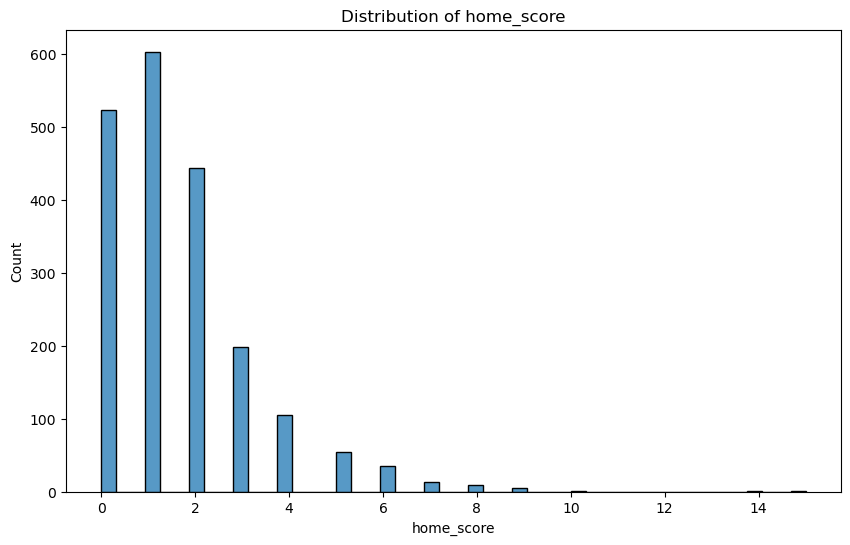

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize distribution of key features
plt.figure(figsize=(10, 6))
sns.histplot(fixtures['home_score'])
plt.title('Distribution of home_score')
plt.show()

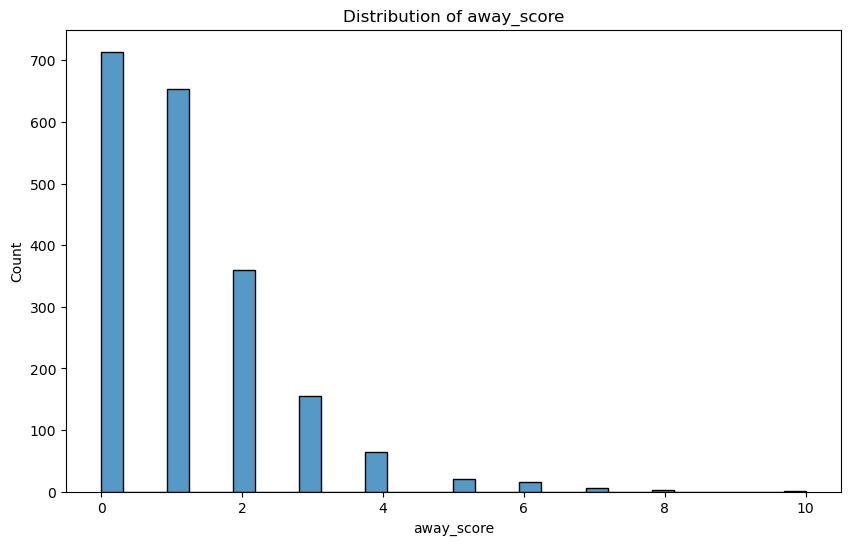

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize distribution of key features
plt.figure(figsize=(10, 6))
sns.histplot(fixtures['away_score'])
plt.title('Distribution of away_score')
plt.show()

In [13]:
# Summary statistics
fixtures.describe()

,fixture_id,home_yellow_cards,home_red_cards,away_yellow_cards,away_red_cards,home_score,away_score,home_score_half_time,away_score_half_time,home_score_conceded,away_score_conceded,time_to_first_goal,time_to_first_goal_home_team,time_to_first_goal_away_team,first_team_to_score_is_home,first_team_to_score_is_away,home_score_ratio,away_score_ratio,away_corner_kicks,away_fouls,away_free_kicks,away_goal_kicks,away_goalkeeper_saves,away_offsides,away_shots_off_target,away_shots_on_target,away_throw_ins,away_total_shots,home_corner_kicks,home_fouls,home_free_kicks,home_goal_kicks,home_goalkeeper_saves,home_offsides,home_shots_off_target,home_shots_on_target,home_throw_ins,home_total_shots,total_offsides_dependent,total_red_cards_dependent,total_yellow_cards_dependent,total_corner_kicks_dependent
count,1.991000e+03,1826.000000,1826.000000,1826.000000,1826.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1878.000000,1849.000000,1849.000000,1849.000000,1843.000000,1791.000000,1859.000000,1860.000000,1850.000000,1831.000000,1878.000000,1849.000000,1849.000000,1849.000000,1843.000000,1791.000000,1859.000000,1860.000000,1850.000000,1831.000000,1791.000000,1826.000000,1826.000000,1878.000000
mean,8.501827e+06,1.686747,0.059693,1.968784,0.062432,1.622300,1.182320,0.729784,0.517328,1.182320,1.622300,37.866901,62.198393,72.438975,0.522351,0.405826,1.112663,1.112663,4.140043,12.138994,12.328286,8.636019,3.217580,1.806253,4.257127,3.787097,19.559459,9.855270,5.308839,12.009194,12.396431,7.188210,2.624525,1.953099,5.217859,4.831720,20.269730,12.233206,3.759352,0.122125,3.655531,9.448882
std,1.818234e+06,1.286563,0.252650,1.323180,0.248704,1.639029,1.287126,0.993098,0.778206,1.287126,1.639029,33.685418,46.020045,47.795441,0.499626,0.491175,1.461707,1.461707,2.902626,4.136685,4.463399,4.228846,2.275984,1.529919,2.672377,2.726130,6.343680,5.791583,3.341420,4.202970,4.394902,3.839481,2.088458,1.534348,3.099773,3.167065,6.507823,6.642610,2.065584,0.363971,1.972736,3.435267
min,5.075602e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,7.116421e+06,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,21.000000,28.000000,0.000000,0.000000,0.000000,0.000000,2.000000,9.000000,9.000000,5.000000,1.000000,1.000000,2.000000,2.000000,15.000000,6.000000,3.000000,9.000000,9.000000,4.000000,1.000000,1.000000,3.000000,3.000000,16.000000,8.000000,2.000000,0.000000,2.000000,7.000000
50%,8.079082e+06,2.000000,0.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,28.000000,49.000000,62.000000,1.000000,0.000000,0.667000,0.667000,4.000000,12.000000,12.000000,8.000000,3.000000,2.000000,4.000000,3.000000,19.000000,9.000000,5.000000,12.000000,12.000000,7.000000,2.000000,2.000000,5.000000,4.000000,20.000000,11.000000,3.000000,0.000000,3.000000,9.000000
75%,1.002335e+07,2.000000,0.000000,3.000000,0.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,52.000000,130.000000,130.000000,1.000000,1.000000,1.500000,1.500000,6.000000,15.000000,15.000000,11.000000,5.000000,3.000000,6.000000,5.000000,24.000000,13.000000,7.000000,15.000000,15.000000,9.000000,4.000000,3.000000,7.000000,7.000000,24.000000,16.000000,5.000000,0.000000,5.000000,12.000000
max,1.238325e+07,7.000000,2.000000,9.000000,2.000000,15.000000,10.000000,8.000000,6.000000,10.000000,15.000000,130.000000,130.000000,130.000000,1.000000,1.000000,14.000000,14.000000,19.000000,33.000000,32.000000,30.000000,14.000000,11.000000,16.000000,24.000000,48.000000,38.000000,22.000000,30.000000,32.000000,24.000000,15.00

In [14]:
# Check for missing values
fixtures.isnull().sum()

fixture_id                        0
home_articipant                   0
away_articipant                   0
start_date                        0
leagueName                        0
home_team_formation              57
away_team_formation              57
home_yellow_cards               165
home_red_cards                  165
away_yellow_cards               165
away_red_cards                  165
home_score                        0
away_score                        0
home_score_half_time              0
away_score_half_time              0
home_score_conceded               0
away_score_conceded               0
time_to_first_goal                0
time_to_first_goal_home_team      0
time_to_first_goal_away_team      0
first_team_to_score             143
first_team_to_score_is_home       0
first_team_to_score_is_away       0
home_score_ratio                  0
away_score_ratio                  0
away_ball_possession            153
away_corner_kicks               113
away_fouls                  

## Feature Selection and Data Preparation

To demonstrate the prediction of a football team's score in Euro 2024, we have deliberately simplified our feature selection process. This approach focuses on a subset of key features to streamline our dataset for effective model training.

We focus on the following essential features:

    current_match_score: Score of the ongoing match.
    participant: Participating team.
    is_home: Boolean indicating home team status.
    opponent: Opposing team.
    last_game_is_home: Boolean indicating the team played their last game at home.
    last_game_score: Score of the team's previous game.

These features are critical for modeling match outcomes and will help us build an effective predictive model for Euro 2024 football matches.

### Feature Selection:

We specifically chose these features to simplify our demonstration:

- current_match_score: Score of the ongoing match.
- participant: Participating team.
- is_home: Boolean indicating home team status.
- opponent: Opposing team.
- last_game_is_home: Boolean indicating if the team played their last game at home.
- last_game_score: Score of the team's previous game.last game was played at home.

These selected features are essential for illustrating the prediction process within the context of Euro 2024 football matches. This simplified approach allows us to focus on demonstrating the core concepts of our predictive model effectively.

We will convert the categofial variables to dummies.
- Note that as of xGboost 2.1.0 we can use df['column'].astype('category') without converting the column to dummies

In [15]:
fixtures = fixtures.sort_values(by='start_date', ascending=False)

In [16]:
df = fixtures.copy()
# Initialize new columns
df['participant'] = None
df['is_home'] = None
df['opponent'] = None
df['last_game_is_home'] = None
df['last_game_score'] = None
df['current_match_score'] = None

# Helper function to get the last game stats
def get_last_game_stats(team, current_index, df):
    last_game = df[(df['home_articipant'] == team) | (df['away_articipant'] == team)].iloc[:current_index]
    if last_game.empty:
        return None, None
    last_game = last_game.iloc[-1]
    last_game_is_home = last_game['home_articipant'] == team
    last_game_score = last_game['home_score'] if last_game_is_home else last_game['away_score']
    return last_game_is_home, last_game_score

# Feature Engineering
# Feature Engineering
rows = []
for i in range(len(df)):
    row = df.iloc[i]
    home_team = row['home_articipant']
    away_team = row['away_articipant']
    
    # Add home team data
    home_row = row.copy()
    home_row['participant'] = home_team
    home_row['is_home'] = 1
    home_row['opponent'] = away_team
    last_game_is_home, last_game_score = get_last_game_stats(home_team, i, df)
    home_row['last_game_is_home'] = last_game_is_home
    home_row['last_game_score'] = last_game_score
    home_row['current_match_score'] = row['home_score']
    rows.append(home_row)

    # Add away team data
    away_row = row.copy()
    away_row['participant'] = away_team
    away_row['is_home'] = 0
    away_row['opponent'] = home_team
    last_game_is_home, last_game_score = get_last_game_stats(away_team, i, df)
    away_row['last_game_is_home'] = last_game_is_home
    away_row['last_game_score'] = last_game_score
    away_row['current_match_score'] = row['away_score']
    rows.append(away_row)

# Create the new dataframe with all rows
model_data = pd.DataFrame(rows)

# Drop rows with missing values (if any)
model_data.dropna(inplace=True)

# Prepare features and target variable
numerical_features = ['current_match_score','is_home', 'last_game_is_home', 'last_game_score']
categorial_features = ['participant','opponent']
model_data = model_data[categorial_features + numerical_features]
dummies = pd.get_dummies(model_data[categorial_features], drop_first=True)
model_data.drop(columns=categorial_features, inplace=True)
model_data =  pd.concat([model_data,dummies], axis=1)
model_data = model_data.astype(int)
model_data.shape

(2980, 184)

In [17]:
model_data.head()

,current_match_score,is_home,last_game_is_home,last_game_score,participant_Algeria,participant_Andorra,participant_Argentina,participant_Armenia,participant_Australia,participant_Austria,participant_Azerbaijan,participant_Belarus,participant_Belgium,participant_Bolivia,participant_Bosnia & Herzegovina,participant_Brazil,participant_Bulgaria,participant_Burkina Faso,participant_Cameroon,participant_Canada,participant_Chile,participant_China,participant_Colombia,participant_Costa Rica,participant_Croatia,participant_Cyprus,participant_Czech Republic,participant_Côte D'Ivoire,participant_Denmark,participant_Ecuador,participant_Egypt,participant_England,participant_Estonia,participant_Faroe Islands,participant_Finland,participant_France,participant_Georgia,participant_Germany,participant_Ghana,participant_Gibraltar,participant_Greece,participant_Hungary,participant_Iceland,participant_Iran,participant_Ireland,participant_Israel,participant_Italy,participant_Japan,participant_Jordan,participant_Kazakhstan,participant_Kosovo,participant_Latvia,participant_Liechtenstein,participant_Lithuania,participant_Luxembourg,participant_Malta,participant_Mexico,participant_Moldova,participant_Mongolia,participant_Montenegro,participant_Morocco,participant_Netherlands,participant_New Zealand,participant_Nigeria,participant_North Macedonia,participant_Northern Ireland,participant_Norway,participant_Panama,participant_Peru,participant_Poland,participant_Portugal,participant_Qatar,participant_Romania,participant_Russia,participant_San Marino,participant_Saudi Arabia,participant_Scotland,participant_Senegal,participant_Serbia,participant_Slovakia,participant_Slovenia,participant_South Africa,participant_South Korea,participant_Spain,participant_Sweden,participant_Switzerland,participant_Thailand,participant_Tunisia,participant_Turkey,participant_USA,participant_Ukraine,participant_Uruguay,participant_Uzbekistan,participant_Wales,opponent_Algeria,opponent_Andorra,opponent_Argentina,opponent_Armenia,opponent_Australia,opponent_Austria,opponent_Azerbaijan,opponent_Belarus,opponent_Belgium,opponent_Bolivia,opponent_Bosnia & Herzegovina,opponent_Brazil,opponent_Bulgaria,opponent_Burkina Faso,opponent_Cameroon,opponent_Canada,opponent_Chile,opponent_China,opponent_Colombia,opponent_Costa Rica,opponent_Croatia,opponent_Cyprus,opponent_Czech Republic,opponent_Côte D'Ivoire,opponent_Denmark,opponent_Ecuador,opponent_Egypt,opponent_England,opponent_Estonia,opponent_Faroe Islands,opponent_Finland,opponent_France,opponent_Georgia,opponent_Germany,opponent_Ghana,opponent_Gibraltar,opponent_Greece,opponent_Hungary,opponent_Iceland,opponent_Iran,opponent_Ireland,opponent_Israel,opponent_Italy,opponent_Japan,opponent_Jordan,opponent_Kazakhstan,opponent_Kosovo,opponent_Latvia,opponent_Liechtenstein,opponent_Lithuania,opponent_Luxembourg,opponent_Malta,opponent_Mexico,opponent_Moldova,opponent_Mongolia,opponent_Montenegro,opponent_Morocco,opponent_Netherlands,opponent_New Zealand,opponent_Nigeria,opponent_North Macedonia,opponent_Northern Ireland,opponent_Norway,opponent_Panama,opponent_Peru,opponent_Poland,opponent_Portugal,opponent_Qatar,opponent_Romania,opponent_Russia,opponent_San Marino,opponent_Saudi Arabia,opponent_Scotland,opponent_Senegal,opponent_Serbia,opponent_Slovakia,opponent_Slovenia,opponent_South Africa,opponent_South Korea,opponent_Spain,opponent_Sweden,opponent_Switzerland,opponent_Thailand,opponent_Tunisia,opponent_Turkey,opponent_USA,opponent_Ukraine,opponent_Uruguay,opponent_Uzbekistan,opponent_Wales
1989,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1989,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Next let's split the data into training, validation, and test sets.  This will help prevent us from overfitting the model, and allow us to test the model's accuracy on data it hasn't already seen.

In [18]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(model_data, test_size=0.2, random_state=42)

train_data.to_csv("train_data.csv", header=False, index=False)
test_data.to_csv("test_data.csv", header=False, index=False)

Now we'll upload these files to S3.

In [19]:
prefix = "sagemaker/DEMO-xgboost-score"
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train/train.csv")
).upload_file("train_data.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation/validation.csv")
).upload_file("test_data.csv")

## Model Training container and data
In this section, we'll train the XGBoost model using SageMaker. First we'll need to specify the locations of the XGBoost algorithm containers.


In [20]:
container = sagemaker.image_uris.retrieve("xgboost", sess.boto_region_name, "1.7-1")
display(container)

'141502667606.dkr.ecr.eu-west-1.amazonaws.com/sagemaker-xgboost:1.7-1'

Then, because we're training with the CSV file format, we'll create `TrainingInput`s that our training function can use as a pointer to the files in S3.

In [21]:
s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train".format(bucket, prefix), content_type="csv"
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/validation/".format(bucket, prefix), content_type="csv"
)

### Understanding XGBoost Hyperparameters

- SageMaker XGBoost has the convention of label in the first column

When setting up an XGBoost model, several key hyperparameters influence its performance:

- `max_depth`: Controls the maximum depth of each tree. Deeper trees can improve fitting but may lead to overfitting and increased computation.
- `subsample`: Manages the sampling of training data to prevent overfitting. However, setting it too low can reduce model effectiveness.
- `num_round`: Dictates the number of boosting rounds, refining the model with each iteration. More rounds can enhance training data fit but increase computation and overfitting risks.
- `eta`: Adjusts boosting aggressiveness, with higher values leading to more conservative boosting.
- `gamma`: Governs tree growth aggressiveness. Larger values promote conservative models.

For more detailed information on XGBoost hyperparameters, refer to their GitHub [documentation](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

### Setting Up Hyperparameter Tuning with SageMaker

1. **Estimator Configuration**:
   - Initialize an XGBoost estimator (`xgb`) with essential parameters.

2. **Hyperparameters**:
   - Define initial settings (`max_depth`, `eta`, etc.) for XGBoost.

3. **Hyperparameter Ranges for HPO**:
   - Specify ranges using `IntegerParameter` and `ContinuousParameter`.

4. **Objective Metric**:
   - Optimize `'validation:mae'` to refine score predictions.

5. **Hyperparameter Tuner Setup**:
   - Configure `HyperparameterTuner` (`tuner`) for automatic optimization.

6. **Starting HPO**:
   - Initiate hyperparameter optimization with `tuner.fit(data_channels)`.

This approach enhances the XGBoost model's accuracy in predicting football team scores, supporting strategic decision-making for Euro 2024.

In [22]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(
    container,
    role=role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)
xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    verbosity=0,
    objective="reg:linear",
    num_round=100,
)

# Define hyperparameter ranges for HPO
hyperparameter_ranges = {
    'max_depth': IntegerParameter(3, 10),
    'eta': ContinuousParameter(0.05, 0.5),
    'gamma': ContinuousParameter(0, 10),
    'min_child_weight': IntegerParameter(1, 10),
    'subsample': ContinuousParameter(0.5, 1),
}

# Define the objective metric to optimize
objective_metric_name = 'validation:mae'

# Set up the HyperparameterTuner
tuner = HyperparameterTuner(
    estimator=xgb,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    strategy='Bayesian',  # or 'Random' for random search
    objective_type='Minimize',
    max_jobs=10,           # Total number of HPO jobs to run
    max_parallel_jobs=2,   # Number of parallel HPO jobs
    early_stopping_type='Auto',
)

# Specify data channels for training
data_channels = {
    'train': s3_input_train,
    'validation': s3_input_validation
}

# Start HPO
tuner.fit(data_channels)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..................................................................................................!


#### Show the best training job name

In [23]:
tuner.best_training_job()

'sagemaker-xgboost-240715-0750-006-2fd4eede'

### Deploying the XGBoost Predictor

To deploy the tuned XGBoost model for predictions, we use SageMaker's `deploy` function with the following parameters:

- **Instance Configuration**: 
  - `initial_instance_count=1`: Specifies one instance for initial deployment.
  - `instance_type="ml.m4.xlarge"`: Uses an `ml.m4.xlarge` instance type for deployment, balancing cost and compute power.
  
- **Serializer Configuration**: 
  - `serializer=CSVSerializer()`: Ensures data sent to the endpoint is serialized in CSV format, suitable for our model's input format.
  
- **Endpoint Name**: 
  - `endpoint_name="TAU-data-science-club-demo"`: Assigns the endpoint a specific name (`TAU-data-science-club-demo`), making it easy to reference and manage.

This deployment process makes the tuned XGBoost model accessible via an endpoint, enabling real-time predictions for Euro 2024 football team scores.

---
## Host

Let's deploy our tuned predictor


####  Deploy the best trained model to an Amazon SageMaker endpoint

In [24]:
xgb_predictor = tuner.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", serializer=CSVSerializer(),
    endpoint_name="TAU-data-science-club-demo"
)


2024-07-15 07:56:55 Starting - Found matching resource for reuse
2024-07-15 07:56:55 Downloading - Downloading the training image
2024-07-15 07:56:55 Training - Training image download completed. Training in progress.
2024-07-15 07:56:55 Uploading - Uploading generated training model
2024-07-15 07:56:55 Completed - Resource reused by training job: sagemaker-xgboost-240715-0750-009-5c71f282
------!

#### Data Serializers and Deserializer

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making a `http` POST request.  But first, we'll need to set up serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

In [25]:
def predict(data):
    # Assuming xgb_predictor.predict can handle the entire data at once
    predictions = xgb_predictor.predict(data).decode("utf-8")
    return predictions.split("\n")[:-1]

## Model Evaluation

In this section, we will evaluate the performance of our XGBoost model using the Mean Absolute Error (MAE) metric. MAE measures the average magnitude of errors in a set of predictions, without considering their direction. It provides a straightforward metric to assess the accuracy of our model's predictions.

We will evaluate our model on both the training and test datasets to check for overfitting. Evaluating on the training data helps us understand how well the model has learned from the data it was trained on, while evaluating on the test data helps us gauge the model's ability to generalize to new, unseen data. A significant difference between the training and test MAE values would suggest potential overfitting.

By carefully comparing the MAE values from the training and test datasets, we can ensure that our model not only fits the training data well but also generalizes effectively to new data, making it a reliable tool for predicting football team scores in Euro 2024.

We will evaluate our model our 

In [26]:
# Predict on train data
predictions_train = predict(train_data.to_numpy()[:, 1:])
predictions_train = np.array(list(map(float, predictions_train)))
actual_values_train = train_data.to_numpy()[:, 0]

# # Predict on test data
predictions_test = predict(test_data.to_numpy()[:, 1:])
predictions_test = np.array(list(map(float, predictions_test)))
actual_values_test = test_data.to_numpy()[:, 0]

In [27]:
# calculate MAE or perform other evaluations
from sklearn.metrics import mean_absolute_error,make_scorer
from sklearn.model_selection import cross_val_score

mae_train = mean_absolute_error(actual_values_train, predictions_train)
mae_test = mean_absolute_error(actual_values_test, predictions_test)

print(f'Mean Absolute Error (Train): {mae_train}')
print(f'Mean Absolute Error (Test): {mae_test}')

Mean Absolute Error (Train): 0.788744923461388
Mean Absolute Error (Test): 0.9268152051599033


Since score will be a round number let's see a sample our predicted scores as int

In [28]:
predictions_test.astype(int)[:5]

array([0, 0, 0, 1, 0])

Next, we'll create a function to generate a feature vector for a single prediction.

In [29]:
def create_feature_vector(columns, team_name, opponent_team, is_home, last_game_home, last_game_score):
    vector=[]
    for col in columns[1:]:
        #print(col)
        if col == 'is_home':
            vector.append(is_home)    
        elif col == 'last_game_is_home_True':
            vector.append(last_game_home)
        elif col == 'last_game_score':
            vector.append(last_game_score)
        elif col == 'participant_'+team_name:
            vector.append(1)
        elif col == 'opponent_'+team_name:
            vector.append(1)
        else:
            vector.append(0)
    return vector

Fianly, let's test our prediction function

In [30]:
team = "Spain"
opponent_team = "France"
game_at_home = 1
last_game_at_home = 0
last_game_score = 2
feature_vector = create_feature_vector(train_data.columns,team, opponent_team, game_at_home, 
                                          last_game_at_home, last_game_score)
print(f"The model prdict {int(float((predict(np.array(feature_vector))[0])))} point for {team} in a match against {opponent_team}")

The model prdict 1 point for Spain in a match against France


In [31]:
team = "France"
opponent_team = "Spain"
game_at_home = 1
last_game_at_home = 0
last_game_score = 2
feature_vector = create_feature_vector(train_data.columns,team, opponent_team, game_at_home, 
                                          last_game_at_home, last_game_score)
print(f"The model prdict {int(float((predict(np.array(feature_vector))[0])))} points for {team}"
      f" in a match against {opponent_team}")

The model prdict 1 points for France in a match against Spain


In [32]:
team = "England"
opponent_team = "Netherlands"
game_at_home = 1
last_game_at_home = 1
last_game_score = 0
feature_vector = create_feature_vector(train_data.columns,team, opponent_team, game_at_home, 
                                          last_game_score, last_game_at_home )
print(f"The model prdict {int(float((predict(np.array(feature_vector))[0])))} point for {team}"
      f" in a match against {opponent_team}")

The model prdict 0 point for England in a match against Netherlands


In [33]:
opponent_team = "Netherlands"
team = "England"
game_at_home = 1
last_game_at_home = 1
last_game_score = 0
feature_vector = create_feature_vector(train_data.columns,team, opponent_team, game_at_home, 
                                          last_game_score, last_game_at_home )
print(f"The model prdict {int(float((predict(np.array(feature_vector))[0])))} point for {team}"
      f" in a match against {opponent_team}")

The model prdict 0 point for England in a match against Netherlands



(Optional) Clean-up

If you're ready to be done with this notebook, please run the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.



In [34]:
xgb_predictor.delete_endpoint()